# Hist2Cell Super-Resolution Tutorial

## Welcome to the Hist2Cell Super-Resolution Guide! 🚀

This tutorial demonstrates how to use a pre-trained **Hist2Cell** model to generate **super-resolved cell abundance maps** from high-resolution histology data. We will take a model trained on standard-resolution data and apply it to 2x higher resolution image patches to predict cell abundances at a finer spatial scale.

### 🎯 What You'll Learn
- ✅ How to load a pre-trained Hist2Cell model and its weights
- ✅ How to prepare high-resolution spatial transcriptomics data for inference
- ✅ How to use `NeighborLoader` for efficient, large-scale inference
- ✅ How to generate and collect super-resolved cell abundance predictions
- ✅ How to visualize these predictions by overlaying them on the original histology slide

### 🔬 Key Concepts
- **Super-Resolution**: The process of generating high-resolution outputs from a model trained on lower-resolution inputs. In this context, we predict cell abundances at locations where we only have high-resolution images, not the original gene expression data.
- **Inference**: Applying a trained model to new, unseen data to make predictions.
- **Leave-One-Out Cross-Validation**: A training strategy where a model is trained on data from all donors except one, which is held out for testing. This rigorously evaluates the model's ability to generalize to new subjects. Here, we use a model where donor `A50` was left out.

## ⚙️ Step 1: Environment Setup

First, we'll configure the computational environment. This involves importing necessary libraries and specifying which GPU to use. Running on a GPU is highly recommended for faster inference.

In [1]:
import os
import torch
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Specify the GPU device(s) to use. Modify this list for your system.
gpu_list = [2]
gpu_list_str = ','.join(map(str, gpu_list))
os.environ.setdefault("CUDA_VISIBLE_DEVICES", gpu_list_str)

# Set the device for PyTorch operations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 🏗️ Step 2: Define the Hist2Cell Model Architecture

Next, we define the `Hist2Cell` model class. This must be the **exact same architecture** that was used for training so that we can correctly load the pre-trained weights.

### 🧠 Model Components Recap:
- **Local Feature Extractor (`ResNet18`)**: Extracts visual features from individual histology image patches.
- **Graph Neural Network (`GATv2Conv`)**: Captures spatial information by exchanging messages between neighboring spots.
- **Global Transformer (`VisionTransformer`)**: Processes the entire tissue context to understand global patterns.
- **Multi-scale Fusion**: The model combines features from the spot, local (neighborhood), and global (tissue-wide) levels to make a final, robust prediction.

In [2]:
from torch.nn import Linear
import torch.nn as nn
import torchvision.models as models
from torch_geometric.nn import GATv2Conv, LayerNorm
import sys,os

# Add the parent directory to the path to import the VisionTransformer module
sys.path.append(os.path.dirname(os.getcwd()))
from model.ViT import Mlp, VisionTransformer


class Hist2Cell(nn.Module):
    """
    The Hist2Cell model architecture, combining a CNN backbone, a GNN for spatial context,
    and a Vision Transformer for global analysis.
    """
    def __init__(self, cell_dim=80, vit_depth=3):
        super(Hist2Cell, self).__init__()
        # 1. Local feature extractor (CNN)
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet18 = torch.nn.Sequential(*list(self.resnet18.children())[:-1])
        
        # Model hyperparameters
        self.embed_dim = 32 * 8
        self.head = 8
        self.dropout = 0.3
        
        # 2. Neighborhood feature extractor (GNN)
        self.conv1 = GATv2Conv(in_channels=512, out_channels=int(self.embed_dim/self.head), heads=self.head)
        self.norm1 = LayerNorm(in_channels=self.embed_dim)
        
        # 3. Global feature extractor (Transformer)
        self.cell_transformer = VisionTransformer(num_classes=cell_dim, embed_dim=self.embed_dim, depth=vit_depth,
                                                  mlp_head=True, drop_rate=self.dropout, attn_drop_rate=self.dropout)
        
        # 4. Multi-scale prediction heads
        self.spot_fc = Linear(in_features=512, out_features=256)
        self.spot_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)      # Spot-level head
        self.local_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)     # Local-level head
        self.fused_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)      # Fused-level head
    
    
    def forward(self, x, edge_index):
        # Extract features from image patches (spot-level)
        x_spot = self.resnet18(x)
        x_spot = x_spot.squeeze()
        
        # Aggregate features from neighbors (local-level)
        x_local = self.conv1(x=x_spot, edge_index=edge_index)
        x_local = self.norm1(x_local)
        
        # Unsqueeze to add a batch dimension for the transformer
        x_local = x_local.unsqueeze(0)
        
        x_cell = x_local
        
        # Make predictions from each scale
        x_spot_processed = self.spot_fc(x_spot)
        cell_predication_spot = self.spot_head(x_spot_processed)
        
        x_local = x_local.squeeze(0)
        cell_prediction_local = self.local_head(x_local)
        
        cell_prediction_global, x_global = self.cell_transformer(x_cell)
        cell_prediction_global = cell_prediction_global.squeeze()
        x_global = x_global.squeeze()
        
        # Fuse features from all three levels for a final prediction
        cell_prediction_fused = self.fused_head((x_spot_processed+x_local+x_global)/3.0)
        
        # Average the predictions from all four heads
        cell_prediction = (cell_predication_spot + cell_prediction_local + cell_prediction_global + cell_prediction_fused) / 4.0
            
        # Apply ReLU activation to ensure non-negative abundance values
        cell_prediction = torch.relu(cell_prediction)
        
        return cell_prediction

## 💾 Step 3: Load Pre-Trained Model Weights

Now we'll load the weights from a pre-trained model. This particular model was trained on the human lung dataset using a **Leave-A50-out** strategy. This means donor `A50` was excluded from the training set, making it a perfect test case to evaluate the model's generalization capabilities.

In [3]:
# Specify the case for the leave-one-out experiment
case = "A50"

# Instantiate the model
model = Hist2Cell(vit_depth=3)

# Load the pre-trained weights (checkpoint file)
checkpoint_path = "../model_weights/humanlung_cell2location_leave_"+case+"_out.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

# Move the model to the selected device (GPU or CPU)
model = model.to(device)

print(f"Model weights loaded from: {checkpoint_path}")
print(f"Model is now on device: {device}")

Model weights loaded from: ../model_weights/humanlung_cell2location_leave_A50_out.pth
Model is now on device: cuda


## 📂 Step 4: Load and Prepare Test Data

We need to identify the slides that belong to our test case (donor `A50`). We do this by loading a predefined text file that lists the slide names for this split. For super-resolution, we will load the **2x resolution** processed data for these slides.

The test slides from donor A50 are:
- `WSA_LngSP9258463`
- `WSA_LngSP9258467`

In [4]:
# Load the list of test slide names from the split file
test_slides_path = "../train_test_splits/humanlung_cell2location/test_leave_"+case+".txt"
test_slides = open(test_slides_path).read().split('\n')
print(f"Found {len(test_slides)} test slides for donor {case}:")
test_slides

Found 2 test slides for donor A50:


['WSA_LngSP9258463', 'WSA_LngSP9258467']

## 🚀 Step 5: Generate Super-Resolved Predictions

This is the core step where we perform inference. We will:
1.  Load the processed **2x resolution** PyTorch Geometric data for each test slide.
2.  Combine them into a single `Batch` object for efficient processing.
3.  Create a `NeighborLoader` to sample 2-hop subgraphs. This allows us to process massive graphs that wouldn't fit into GPU memory all at once.
4.  Iterate through the `NeighborLoader`, pass each subgraph batch to the model, and collect the predictions.
5.  Organize the final predictions into a dictionary, keyed by the slide name.

In [5]:
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import torch_geometric
torch_geometric.typing.WITH_PYG_LIB = False
from torch_geometric.data import Batch
import numpy as np
from scipy.stats import pearsonr

# --- DataLoader Configuration ---
hop = 2               # Use a 2-hop neighborhood for spatial context
subgraph_bs = 16      # Subgraph batch size (adjust based on GPU memory)

# 1. Load all 2x resolution test graphs into a list
print("Loading 2x resolution data for test slides...")
test_graph_list = list()
for item in test_slides:
    data_path = os.path.join("../example_data/humanlung_cell2location_2x", item+'.pt')
    print(f" -> Loading {data_path}")
    test_graph_list.append(torch.load(data_path))

# 2. Create a single large batch object from the list of graphs
test_dataset = Batch.from_data_list(test_graph_list)
print(f"\nCreated a batched dataset with {test_dataset.num_graphs} graphs and {test_dataset.num_nodes} total nodes.")

# 3. Create the NeighborLoader for efficient subgraph sampling
test_loader = NeighborLoader(
    test_dataset,               # The batched graph data
    num_neighbors=[-1]*hop,     # Sample all neighbors at each hop
    batch_size=subgraph_bs,     # Number of center nodes per batch
    directed=False,             # The graph is undirected
    input_nodes=None,           # Use all nodes as potential centers
    shuffle=False,              # Do not shuffle for inference to maintain order
    num_workers=2,              # Parallel workers for data loading
)
print(f"NeighborLoader configured for {hop}-hop sampling with batch size {subgraph_bs}.")

# --- Inference Loop ---
print("\nStarting inference to generate super-resolved predictions...")
with torch.no_grad(): # Disable gradient calculations for efficiency
    model.eval() # Set the model to evaluation mode
    
    # Lists to store results
    test_cell_pred_array = []
    test_cell_label_array = []
    test_cell_pos_array = []
    
    # 4. Iterate through the subgraph batches
    for graph in tqdm(test_loader, desc="Processing subgraphs"):
        # Move data to the GPU
        x = graph.x.to(device)
        y = graph.y.to(device)
        pos = graph.pos.to(device)
        edge_index = graph.edge_index.to(device)
        
        # The ground truth labels are the last 80 columns
        cell_label = y[:, 250:]
        
        # Get model predictions
        cell_pred = model(x=x, edge_index=edge_index)

        # We only need the predictions for the center nodes of each subgraph
        center_num = len(graph.input_id)
        center_cell_label = cell_label[:center_num, :]
        center_cell_pred = cell_pred[:center_num, :]
        center_cell_pos = pos[:center_num, :]
        
        # Append results to lists (move back to CPU)
        test_cell_label_array.append(center_cell_label.squeeze().cpu().detach().numpy())
        test_cell_pred_array.append(center_cell_pred.squeeze().cpu().detach().numpy())
        test_cell_pos_array.append(center_cell_pos.squeeze().cpu().detach().numpy())
        

    # --- Post-processing ---
    # Concatenate results from all batches into single numpy arrays
    if len(test_cell_pred_array[-1].shape) == 1:
        test_cell_pred_array[-1] = np.expand_dims(test_cell_pred_array[-1], axis=0)
    test_cell_pred_array = np.concatenate(test_cell_pred_array)
    
    if len(test_cell_label_array[-1].shape) == 1:
        test_cell_label_array[-1] = np.expand_dims(test_cell_label_array[-1], axis=0)
    test_cell_label_array = np.concatenate(test_cell_label_array)
    
    if len(test_cell_pos_array[-1].shape) == 1:
        test_cell_pos_array[-1] = np.expand_dims(test_cell_pos_array[-1], axis=0)
    test_cell_pos_array = np.concatenate(test_cell_pos_array)
    

    # 5. Organize predictions into a final dictionary
    Predictions = dict()
    for slide_no in range(len(test_slides)):
        # Find the indices corresponding to each original slide
        indices = np.where(test_dataset.batch.numpy() == slide_no)
        test_cell_pred_array_sub = test_cell_pred_array[indices]
        test_cell_label_array_sub = test_cell_label_array[indices]
        test_cell_pos_arraay_sub = test_cell_pos_array[indices]
        
        Predictions[test_slides[slide_no]] = {
            'cell_abundance_predictions': test_cell_pred_array_sub,
            'cell_abundance_labels': test_cell_label_array_sub,
            'coords': test_cell_pos_arraay_sub,
        }
print("\nInference complete. Predictions are stored.")

Loading 2x resolution data for test slides...
 -> Loading ../example_data/humanlung_cell2location_2x/WSA_LngSP9258463.pt
 -> Loading ../example_data/humanlung_cell2location_2x/WSA_LngSP9258467.pt

Created a batched dataset with 2 graphs and 2991 total nodes.
NeighborLoader configured for 2-hop sampling with batch size 16.

Starting inference to generate super-resolved predictions...


Processing subgraphs: 100%|██████████| 187/187 [00:33<00:00,  5.65it/s]


Inference complete. Predictions are stored.


### 🔍 Inspecting the Prediction Output

Let's check the keys of our `Predictions` dictionary to confirm that we have results for both test slides.

In [6]:
Predictions.keys()

dict_keys(['WSA_LngSP9258463', 'WSA_LngSP9258467'])

Now let's examine the contents for a single slide. For each spot, we should have the predicted cell abundances, the ground-truth labels (from the original data), and its spatial coordinates.

In [7]:
Predictions['WSA_LngSP9258467'].keys()

dict_keys(['cell_abundance_predictions', 'cell_abundance_labels', 'coords'])

## 🎨 Step 6: Visualize Super-Resolved Cell Abundance

The final step is to visualize our results. We'll create a function to plot the predicted cell abundance of a specific cell type as a scatter plot, overlaid on the low-resolution histology image. This allows us to visually inspect the spatial distribution of different cell types at a 2x higher resolution, as shown in `Fig 6` of the Hist2Cell paper.

In [8]:
import matplotlib.pyplot as plt
from PIL import Image


def plot_cell_abundance(img, X, Y, cell_abundance, cell_name, cmap='viridis', s=95):
    """
    Visualizes cell abundance by overlaying a scatter plot on a histology image.

    Args:
        img (PIL.Image): The background histology image.
        X (array): X-coordinates of the spots.
        Y (array): Y-coordinates of the spots.
        cell_abundance (array): The predicted abundance values for each spot.
        cell_name (str): The name of the cell type being plotted.
        cmap (str): The colormap for the scatter plot.
        s (int): The size of the scatter plot points.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    # The image needs to be flipped to match the coordinate system
    ax.imshow(img.transpose(Image.FLIP_TOP_BOTTOM).transpose(Image.FLIP_LEFT_RIGHT))

    # Create the scatter plot. Coordinates are transformed to match the flipped image.
    sc = ax.scatter(img.size[0] - (X), img.size[1] - (Y),
                    c=cell_abundance,
                    s=s, alpha=0.80, cmap=cmap)

    # Zoom into the tissue area
    ax.set_xlim(img.size[0] - (min(X)-50), img.size[0] - (max(X)+50))
    ax.set_ylim(img.size[1] - (min(Y)-50), img.size[1] - (max(Y)+50))
    ax.set_ylim(ax.get_ylim()[::-1]) # Invert y-axis to match image orientation

    # Clean up the plot
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a colorbar to show the abundance scale
    cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Predicted Abundance', rotation=270, labelpad=20, fontsize=14)
    
    ax.set_title(cell_name, fontsize=16)  
    
    plt.show()

### 📊 Generating Plots for Key Cell Types

Now, we'll loop through a list of important cell types and generate a visualization for each one on the `WSA_LngSP9258467` slide.

Generating visualizations for slide: WSA_LngSP9258467



Generating plots:   0%|          | 0/11 [00:00<?, ?it/s]

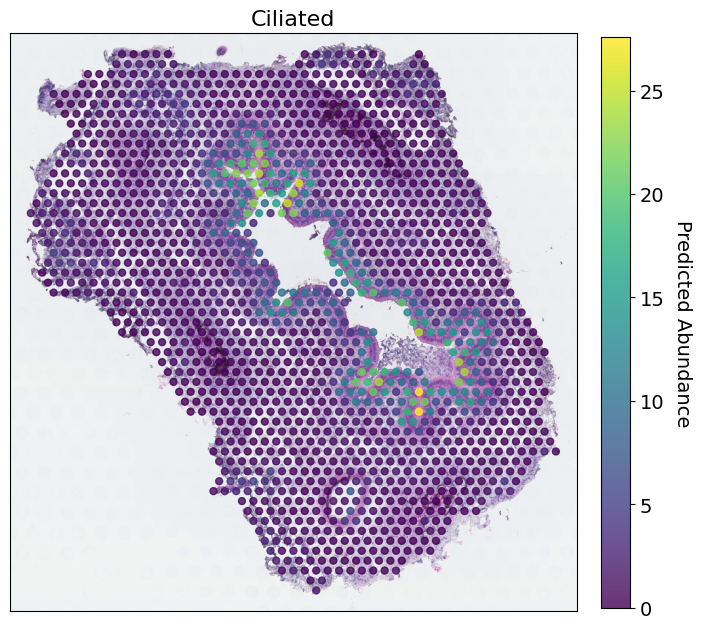

Generating plots:   9%|▉         | 1/11 [00:10<01:43, 10.32s/it]

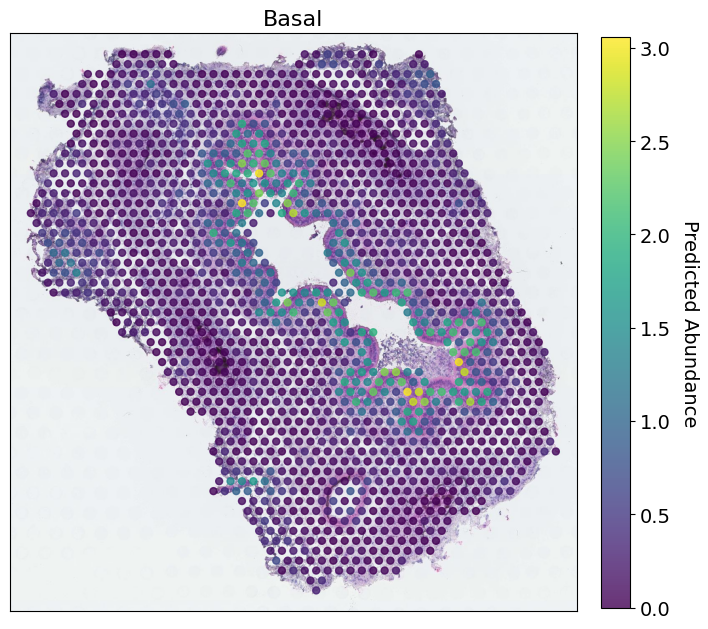

Generating plots:  18%|█▊        | 2/11 [00:18<01:20,  8.97s/it]

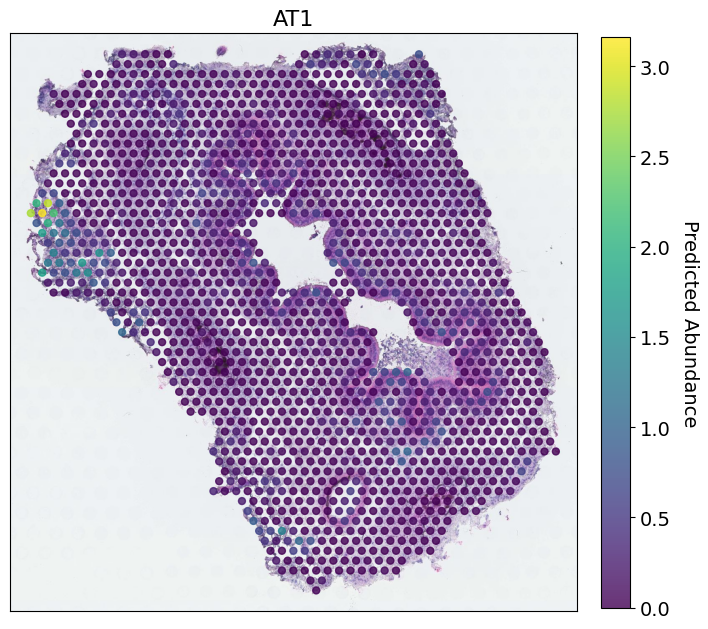

Generating plots:  27%|██▋       | 3/11 [00:22<00:54,  6.84s/it]

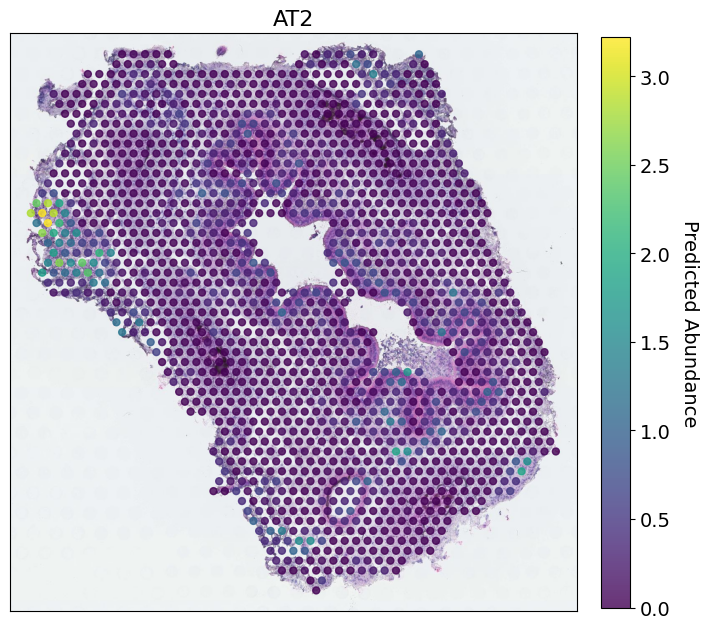

Generating plots:  36%|███▋      | 4/11 [00:26<00:39,  5.63s/it]

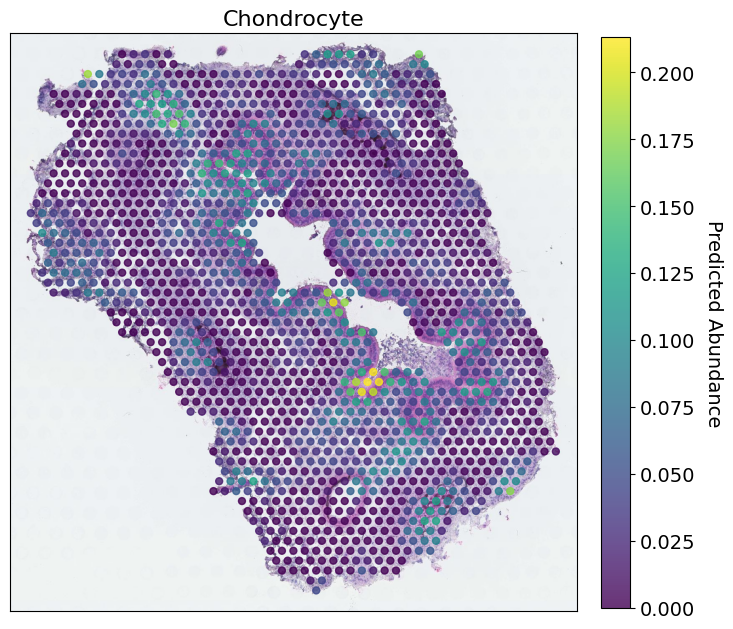

Generating plots:  45%|████▌     | 5/11 [00:28<00:26,  4.34s/it]

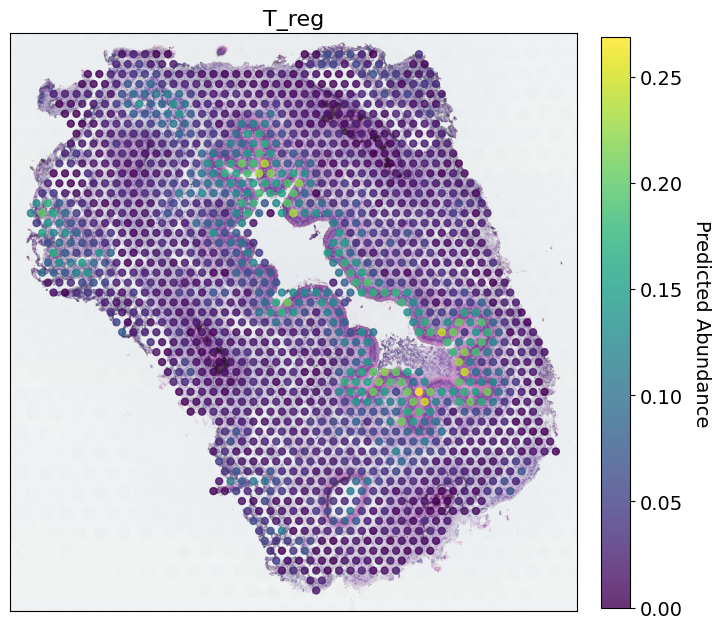

Generating plots:  55%|█████▍    | 6/11 [00:31<00:19,  3.96s/it]

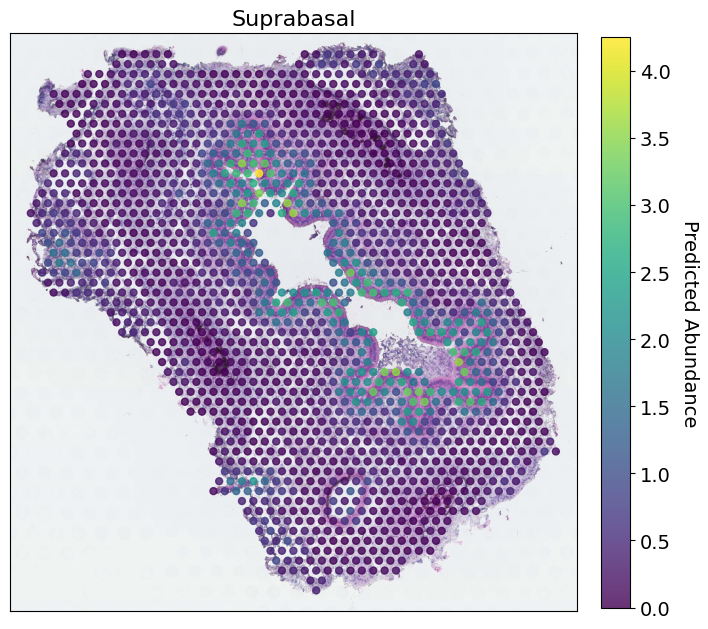

Generating plots:  64%|██████▎   | 7/11 [00:35<00:15,  3.78s/it]

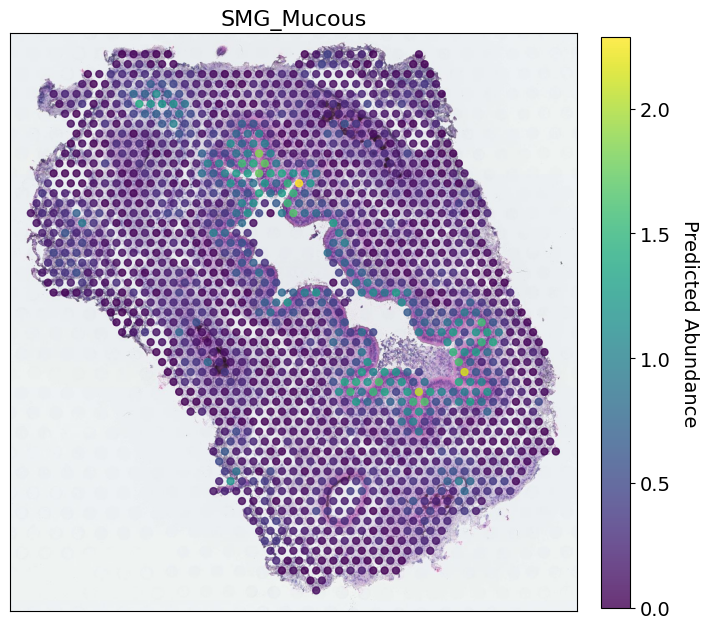

Generating plots:  73%|███████▎  | 8/11 [00:38<00:11,  3.67s/it]

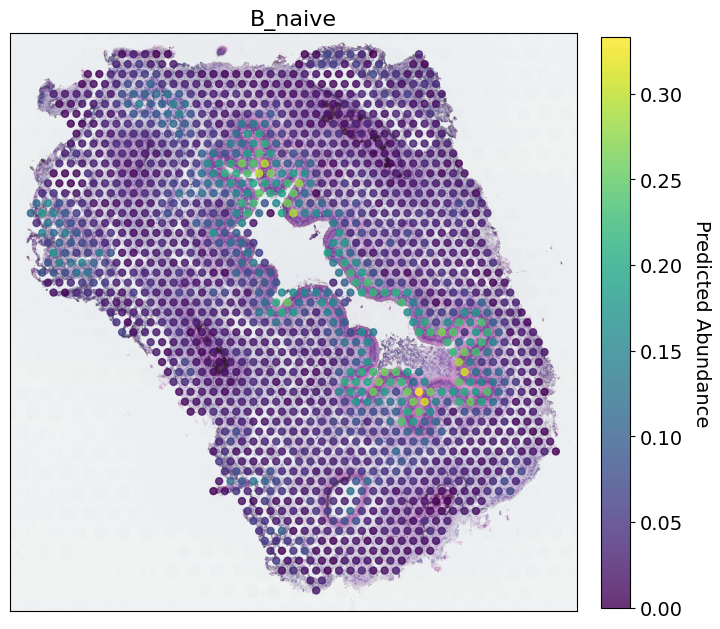

Generating plots:  82%|████████▏ | 9/11 [00:42<00:07,  3.69s/it]

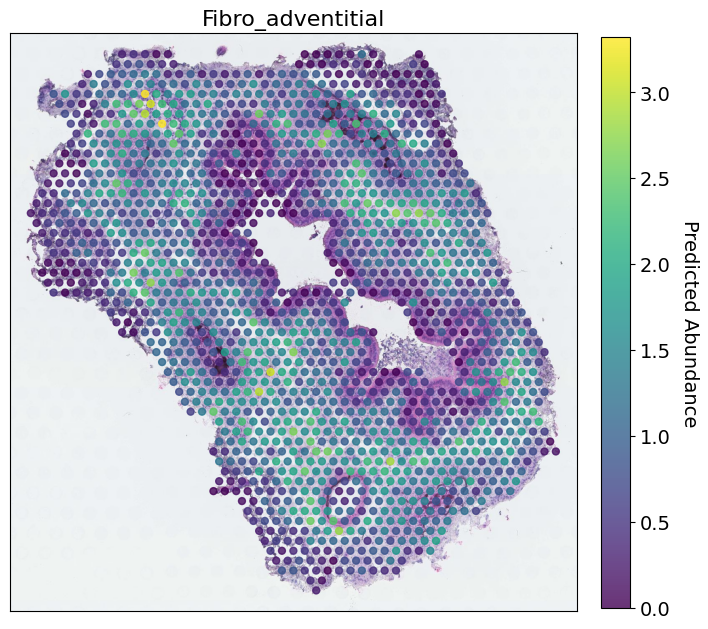

Generating plots:  91%|█████████ | 10/11 [00:49<00:04,  4.83s/it]

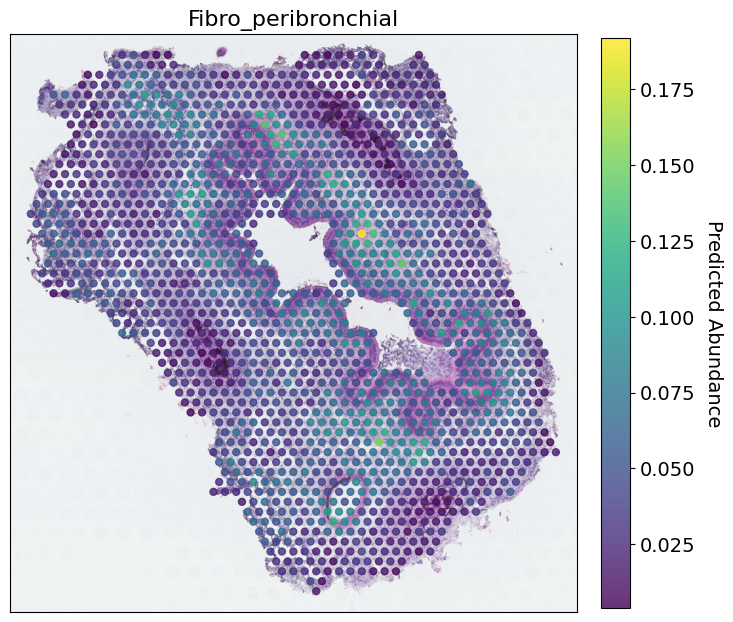

Generating plots: 100%|██████████| 11/11 [00:57<00:00,  5.23s/it]


In [9]:
import joblib
from tqdm import tqdm

# Define the slide to visualize
slide = "WSA_LngSP9258467"
print(f"Generating visualizations for slide: {slide}\n")

# Load the list of all 80 cell type names
cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types.pkl")
# Define a subset of cell types for visualization
visualize_cell_names = ['Ciliated', 'Basal', 'AT1', 'AT2', 'Chondrocyte', 'T_reg', 'Suprabasal', 'SMG_Mucous', 'B_naive', 'Fibro_adventitial', 'Fibro_peribronchial']

# Get the predicted abundances and coordinates for the selected slide
hist2cell_abundances = np.clip(Predictions[slide]['cell_abundance_predictions'], a_min=0, a_max=None) # Ensure non-negative
coordinates = Predictions[slide]['coords']

# The super-resolution coordinates are 4x the low-res image, so we scale them down
X = coordinates[:, 0] / 4
Y = coordinates[:, 1] / 4

# Load the corresponding low-resolution histology image
jpg_path = '../example_data/humanlung_cell2location/'+slide+'_low_res.jpg'
img = Image.open(jpg_path)

# Loop through each cell type and create a plot
for i in tqdm(range(len(visualize_cell_names)), desc="Generating plots"):
    cell_name = visualize_cell_names[i]
    # Find the index of the current cell type
    cell_idx = cell_types.index(cell_name)
    # Call the plotting function
    plot_cell_abundance(img, X, Y, hist2cell_abundances[:, cell_idx], cell_name, cmap='viridis', s=25)

## 💡 Advanced Concepts & Next Steps

### Prediction vs. Imputation Super-Resolution
What we performed in this tutorial is **prediction-based super-resolution**. We used a generalized model to predict on new, high-resolution data. 

Another approach is **imputation-based super-resolution**. For this, one would take a single slide, intentionally "overfit" the Hist2Cell model on its low-resolution data, and then use that highly specialized model to predict on the high-resolution patches from the *same slide*. This can be useful for filling in fine-grained details within a known tissue section. To do this, you would follow the `training_tutorial.ipynb` using data from only a single slide.

### Scalability to Higher Resolutions
While this tutorial demonstrated 2x super-resolution, the `Hist2Cell` framework can scale to even higher resolutions (e.g., 4x, 8x). Because its inference is done on small, 2-hop subgraphs, it is very memory-efficient. Generating higher-resolution maps simply requires more inference time, but not necessarily more GPU memory, making it feasible on commercial GPUs.

### 🎉 Tutorial Complete!
You have now successfully generated and visualized super-resolved cell abundance maps using Hist2Cell. You can adapt this workflow to:
- Apply it to your own high-resolution spatial transcriptomics data.
- Use different pre-trained models.
- Explore the spatial distribution of all 80 cell types.